Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.25MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.5MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.64MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Epoch [10/50]
Average Loss: 105.2045
Reconstruction Loss: 87.0846
KL Loss: 18.1199

Epoch [20/50]
Average Loss: 100.7017
Reconstruction Loss: 81.4091
KL Loss: 19.2926

Epoch [30/50]
Average Loss: 99.0139
Reconstruction Loss: 79.3985
KL Loss: 19.6154

Epoch [40/50]
Average Loss: 98.0167
Reconstruction Loss: 78.2465
KL Loss: 19.7702

Epoch [50/50]
Average Loss: 97.3193
Reconstruction Loss: 77.4666
KL Loss: 19.8527



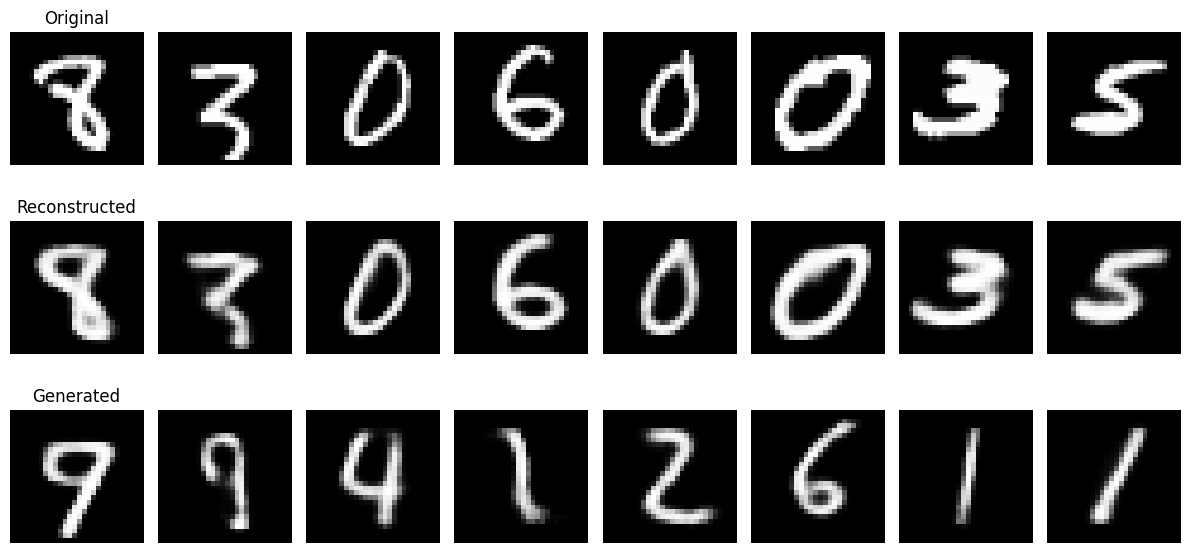

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Latent space parameters
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # For MNIST images (values between 0 and 1)
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def train_vae(model, train_loader, num_epochs=50, learning_rate=1e-3, device='cuda'):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        recon_loss_total = 0
        kl_loss_total = 0

        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(data)

            # Reconstruction loss (binary cross entropy)
            recon_loss = nn.functional.binary_cross_entropy(
                recon_batch, data.view(-1, 784), reduction='sum')

            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Total loss
            loss = recon_loss + kl_loss

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()

        # Print epoch statistics
        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon_loss = recon_loss_total / len(train_loader.dataset)
        avg_kl_loss = kl_loss_total / len(train_loader.dataset)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Average Loss: {avg_loss:.4f}')
            print(f'Reconstruction Loss: {avg_recon_loss:.4f}')
            print(f'KL Loss: {avg_kl_loss:.4f}\n')

def visualize_results(model, test_loader, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Get a batch of test data
        data, _ = next(iter(test_loader))
        data = data.to(device)

        # Reconstruct images
        recon_batch, _, _ = model(data)

        # Generate new images from random latent vectors
        z = torch.randn(8, 20).to(device)
        generated = model.decode(z)

        # Plot results
        plt.figure(figsize=(12, 6))

        # Original images
        for i in range(8):
            plt.subplot(3, 8, i + 1)
            plt.imshow(data[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Original')

        # Reconstructed images
        for i in range(8):
            plt.subplot(3, 8, i + 9)
            plt.imshow(recon_batch[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Reconstructed')

        # Generated images
        for i in range(8):
            plt.subplot(3, 8, i + 17)
            plt.imshow(generated[i].cpu().numpy().reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == 0:
                plt.title('Generated')

        plt.tight_layout()
        plt.show()

def main():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load MNIST dataset
    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

    # Initialize model
    model = VAE().to(device)

    # Train the model
    train_vae(model, train_loader, device=device)

    # Visualize results
    visualize_results(model, test_loader, device=device)

if __name__ == "__main__":
    main()

Epoch [10/100]
D Loss: 0.6463, G Loss: 0.8674


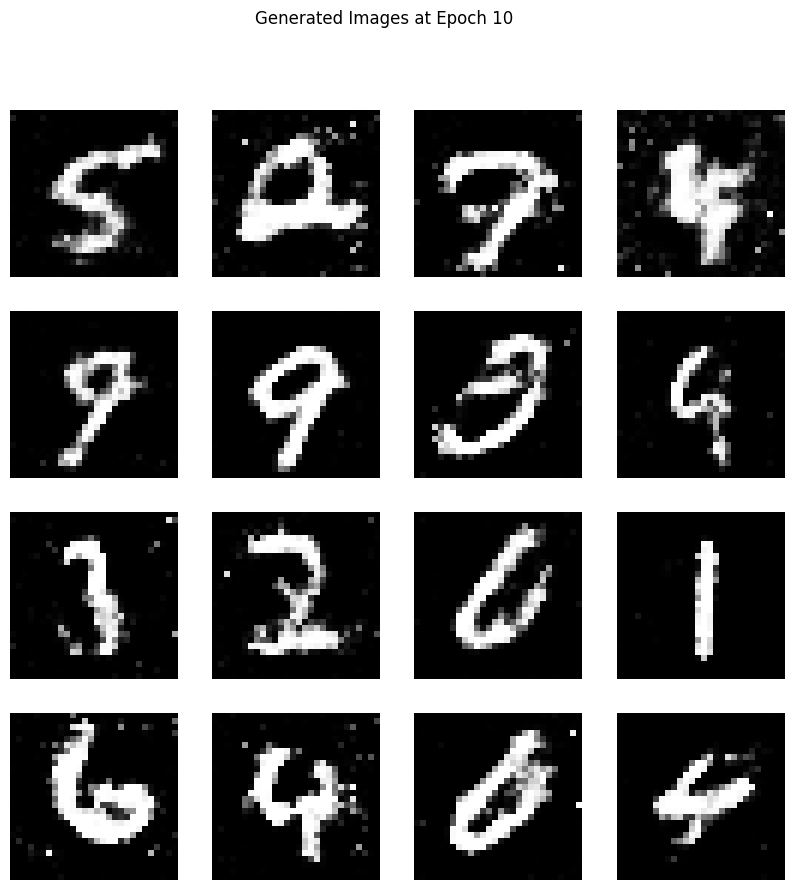

Epoch [20/100]
D Loss: 0.6556, G Loss: 0.8354


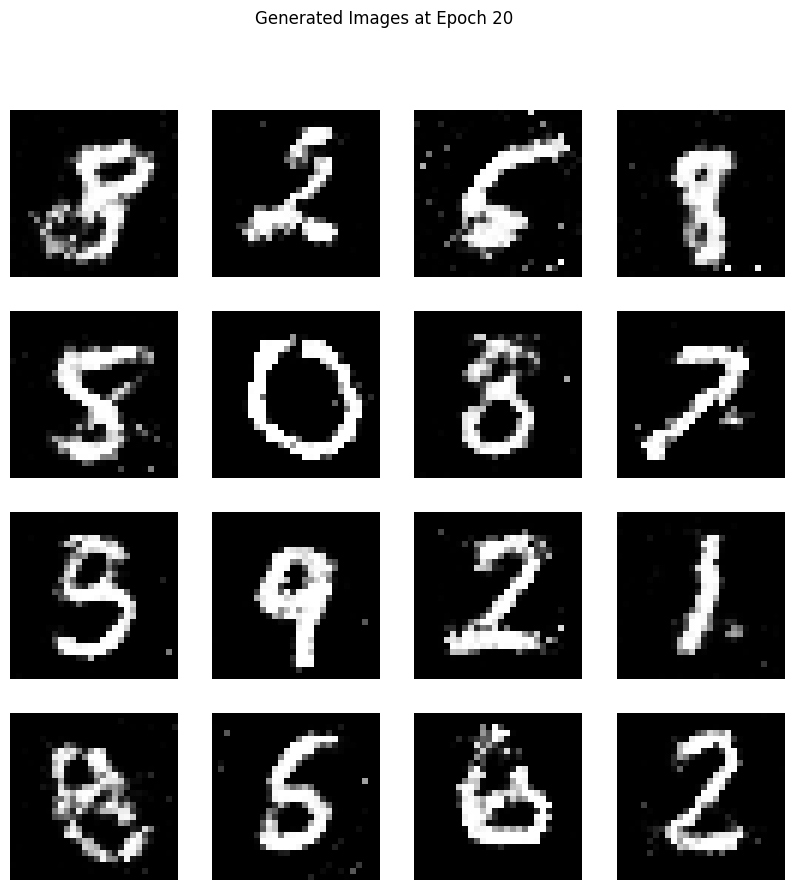

Epoch [30/100]
D Loss: 0.6547, G Loss: 0.8346


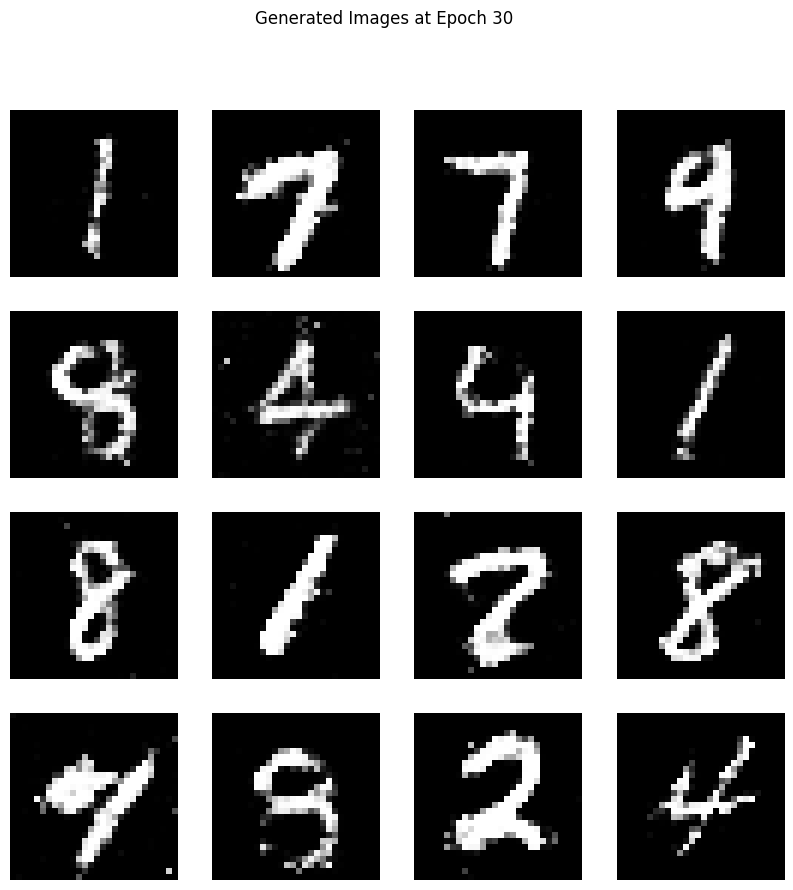

Epoch [40/100]
D Loss: 0.6541, G Loss: 0.8382


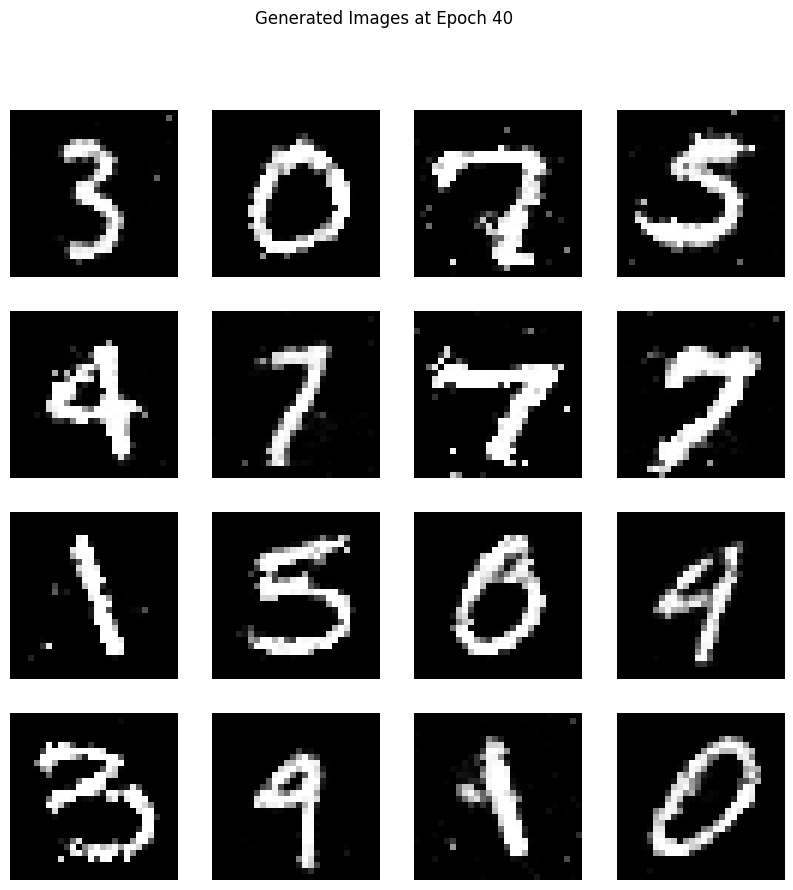

Epoch [50/100]
D Loss: 0.6514, G Loss: 0.8502


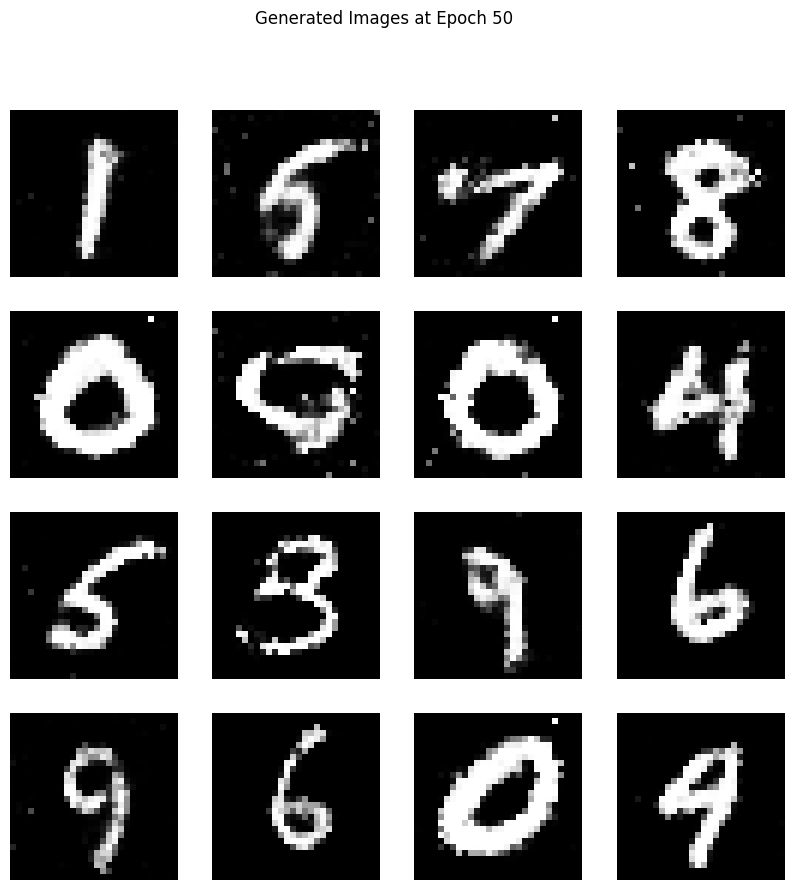

Epoch [60/100]
D Loss: 0.6465, G Loss: 0.8673


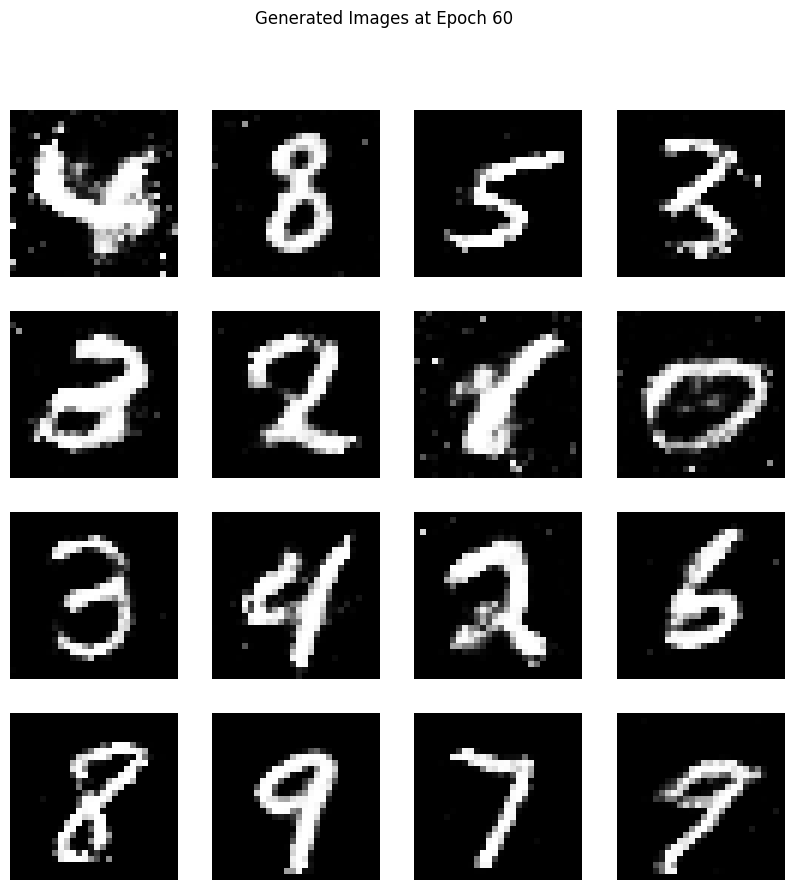

Epoch [70/100]
D Loss: 0.6387, G Loss: 0.8872


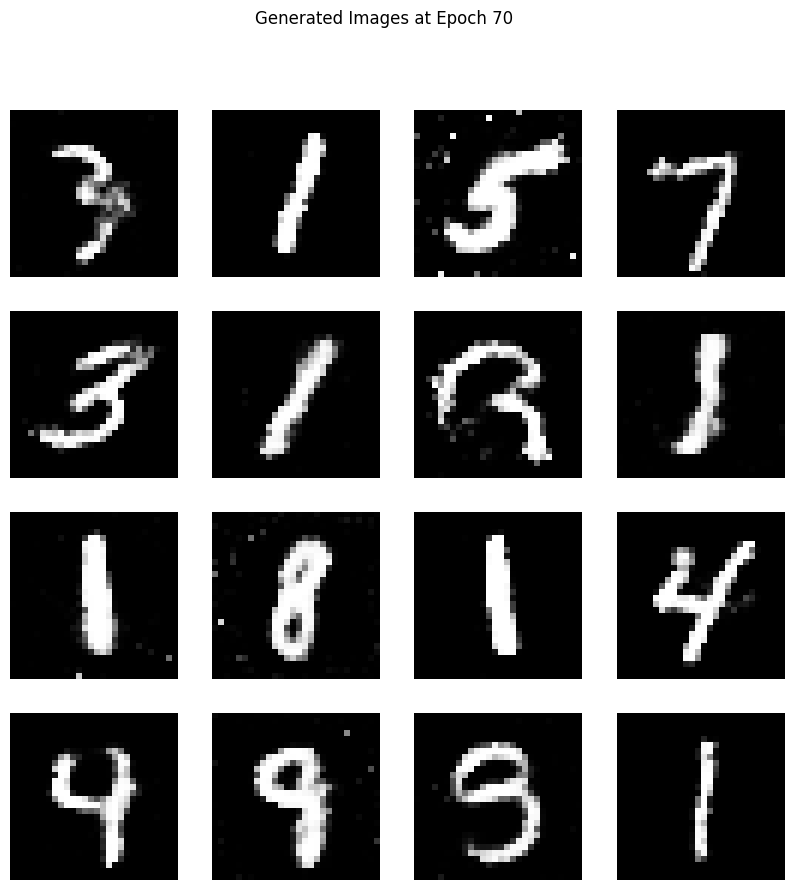

Epoch [80/100]
D Loss: 0.6333, G Loss: 0.9127


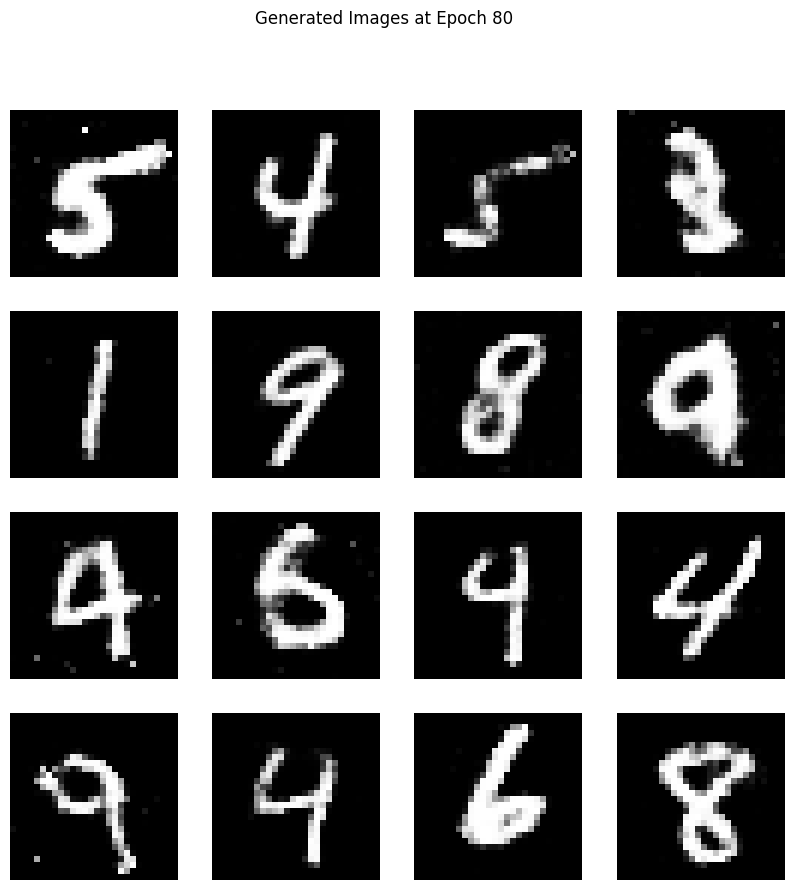

Epoch [90/100]
D Loss: 0.6286, G Loss: 0.9258


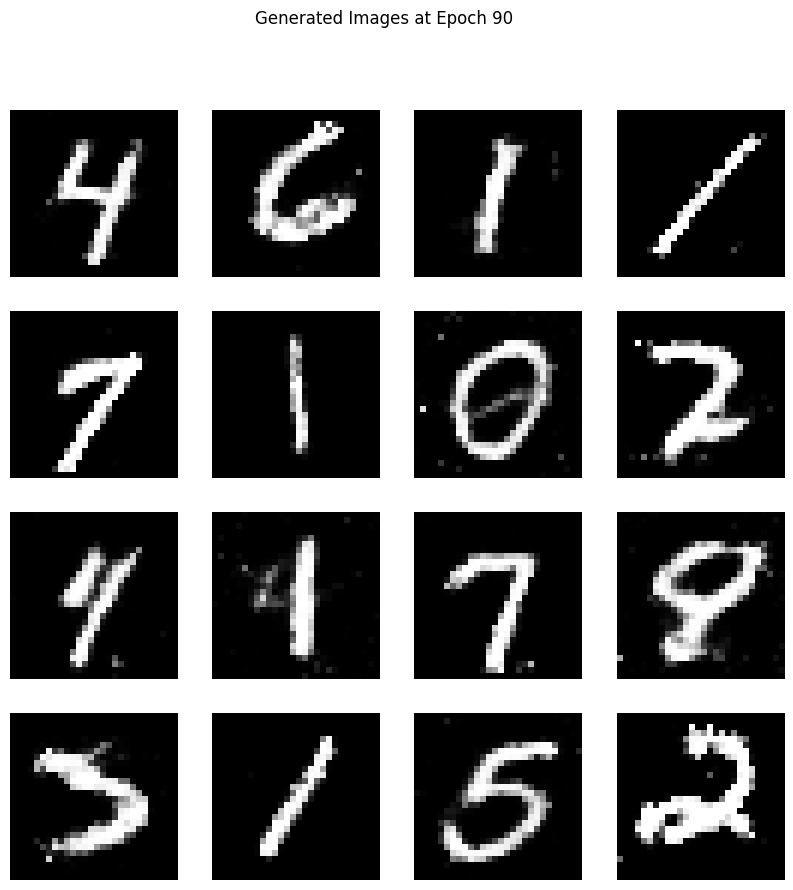

Epoch [100/100]
D Loss: 0.6210, G Loss: 0.9537


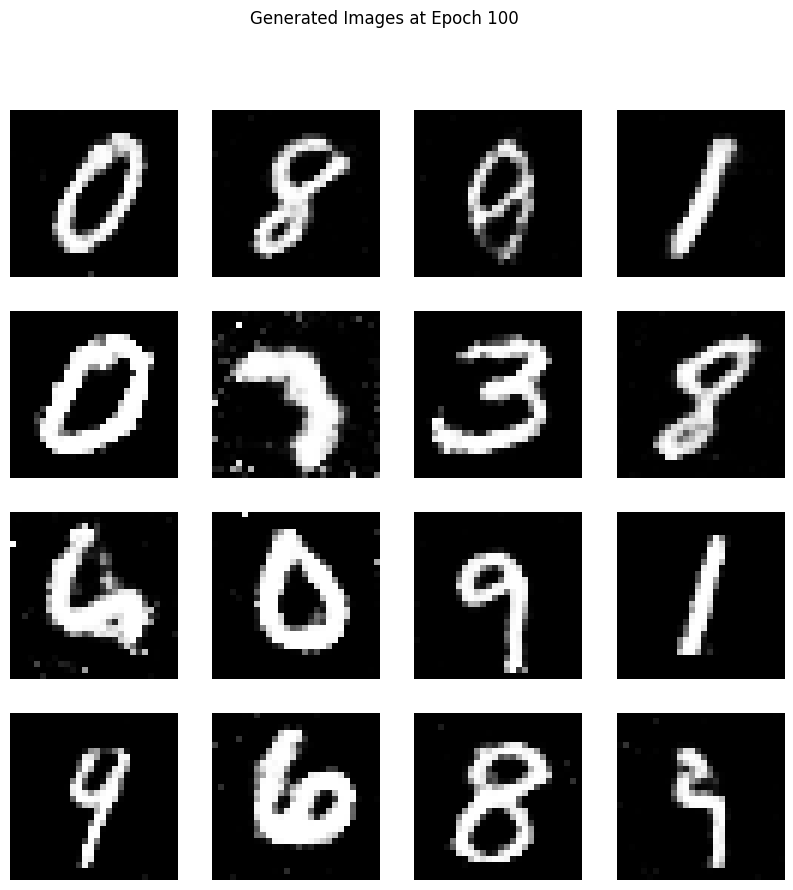


Generating final results...


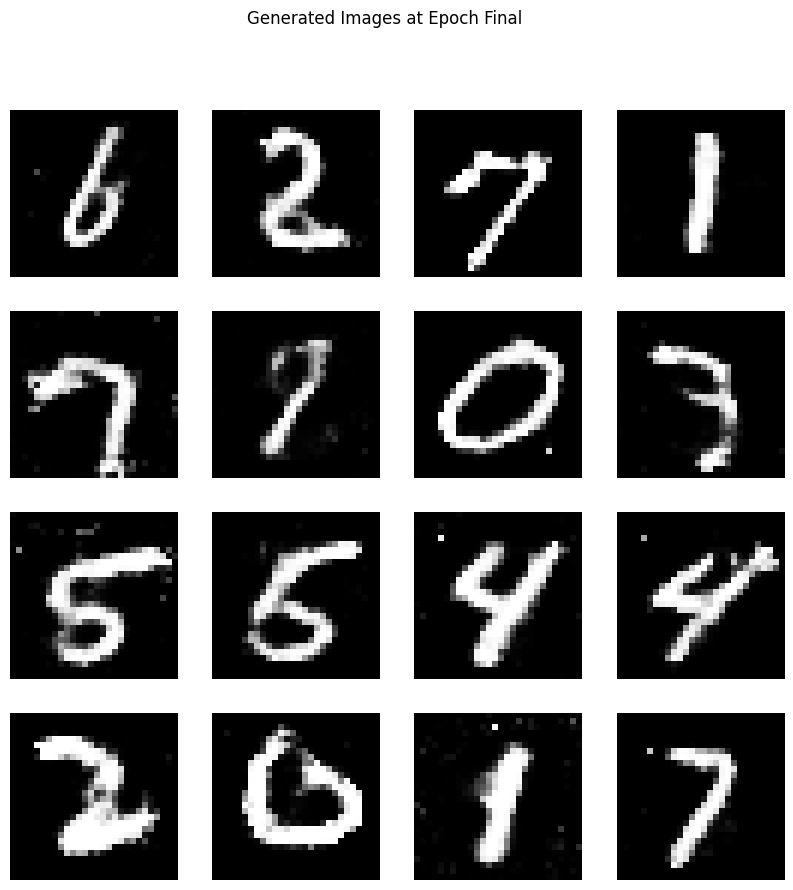

In [2]:
# Generator Network
class Generator(nn.Module):
    def __init__(self, latent_dim=100, hidden_dim=256):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim),

            # Second hidden layer
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 2),

            # Third hidden layer
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(hidden_dim * 4),

            # Output layer
            nn.Linear(hidden_dim * 4, 784),  # 28x28 = 784 (MNIST image size)
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)  # Reshape to image format

# Discriminator Network
class Discriminator(nn.Module):
    def __init__(self, hidden_dim=256):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # First hidden layer
            nn.Linear(784, hidden_dim * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Second hidden layer
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Third hidden layer
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Output layer
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, img):
        img_flat = img.view(-1, 784)
        validity = self.model(img_flat)
        return validity

class GAN:
    def __init__(self, latent_dim=100, hidden_dim=256, device='cuda'):
        self.latent_dim = latent_dim
        self.device = device

        # Initialize generator and discriminator
        self.generator = Generator(latent_dim, hidden_dim).to(device)
        self.discriminator = Discriminator(hidden_dim).to(device)

        # Loss function
        self.adversarial_loss = nn.BCELoss()

        # Optimizers
        self.g_optimizer = optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_optimizer = optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train_step(self, real_imgs):
        batch_size = real_imgs.size(0)
        real_label = torch.ones(batch_size, 1).to(self.device)
        fake_label = torch.zeros(batch_size, 1).to(self.device)

        # Train Discriminator
        self.d_optimizer.zero_grad()

        # Loss on real images
        real_pred = self.discriminator(real_imgs)
        d_loss_real = self.adversarial_loss(real_pred, real_label)

        # Loss on fake images
        z = torch.randn(batch_size, self.latent_dim).to(self.device)
        fake_imgs = self.generator(z)
        fake_pred = self.discriminator(fake_imgs.detach())
        d_loss_fake = self.adversarial_loss(fake_pred, fake_label)

        # Total discriminator loss
        d_loss = (d_loss_real + d_loss_fake) / 2
        d_loss.backward()
        self.d_optimizer.step()

        # Train Generator
        self.g_optimizer.zero_grad()

        # Generate images and compute loss
        fake_pred = self.discriminator(fake_imgs)
        g_loss = self.adversarial_loss(fake_pred, real_label)

        g_loss.backward()
        self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

def train_gan(gan, train_loader, num_epochs=100):
    g_losses = []
    d_losses = []

    for epoch in range(num_epochs):
        epoch_g_losses = []
        epoch_d_losses = []

        for batch_idx, (real_imgs, _) in enumerate(train_loader):
            real_imgs = real_imgs.to(gan.device)

            # Train GAN
            d_loss, g_loss = gan.train_step(real_imgs)

            epoch_d_losses.append(d_loss)
            epoch_g_losses.append(g_loss)

        # Calculate average epoch losses
        avg_d_loss = np.mean(epoch_d_losses)
        avg_g_loss = np.mean(epoch_g_losses)

        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
            visualize_progress(gan, epoch + 1)

def visualize_progress(gan, epoch):
    gan.generator.eval()
    with torch.no_grad():
        # Generate fake images
        z = torch.randn(16, gan.latent_dim).to(gan.device)
        fake_imgs = gan.generator(z)

        # Plot the fake images
        plt.figure(figsize=(10, 10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_imgs[i, 0].cpu().numpy(), cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Generated Images at Epoch {epoch}')
        plt.show()
    gan.generator.train()

def mainGAN():
    # Set random seed for reproducibility
    torch.manual_seed(42)

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Initialize and train GAN
    gan = GAN(device=device)
    train_gan(gan, train_loader)

    # Generate final results
    print("\nGenerating final results...")
    visualize_progress(gan, "Final")

if __name__ == "__main__":
    mainGAN()

1. VAE Latent Space Visualization


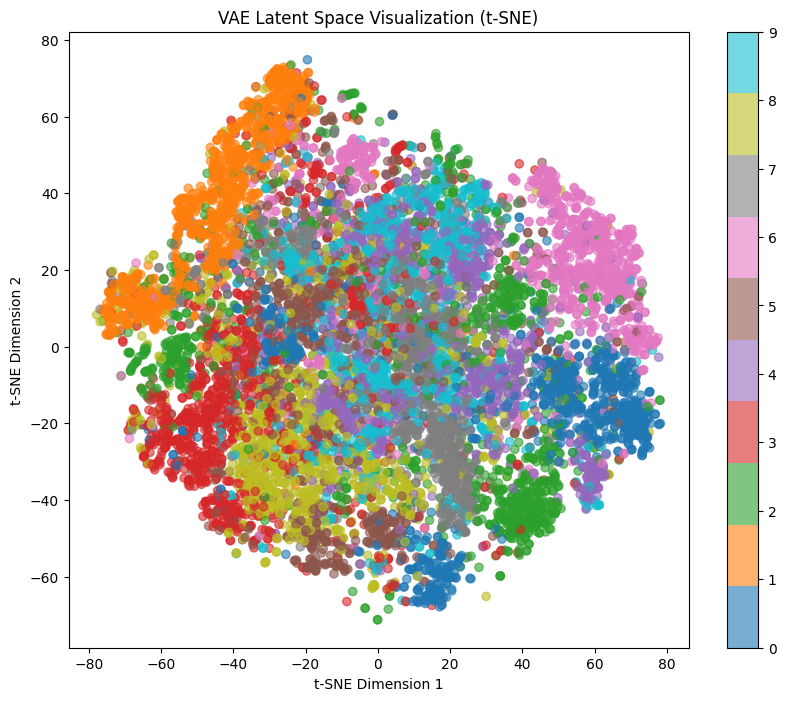


2. VAE Reconstructions


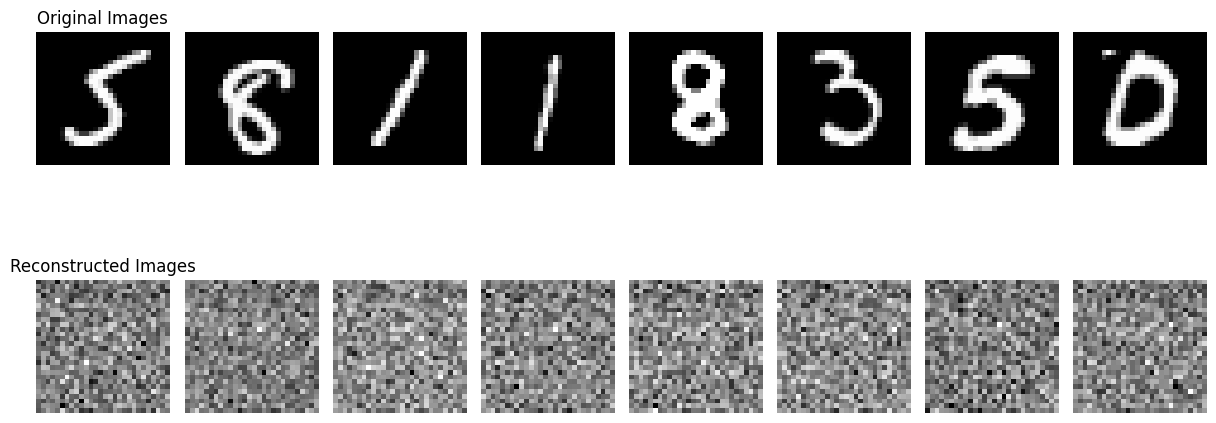


3. VAE Generated Images


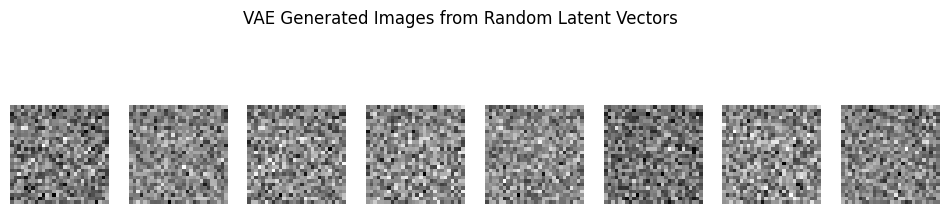


4. GAN Generated Images


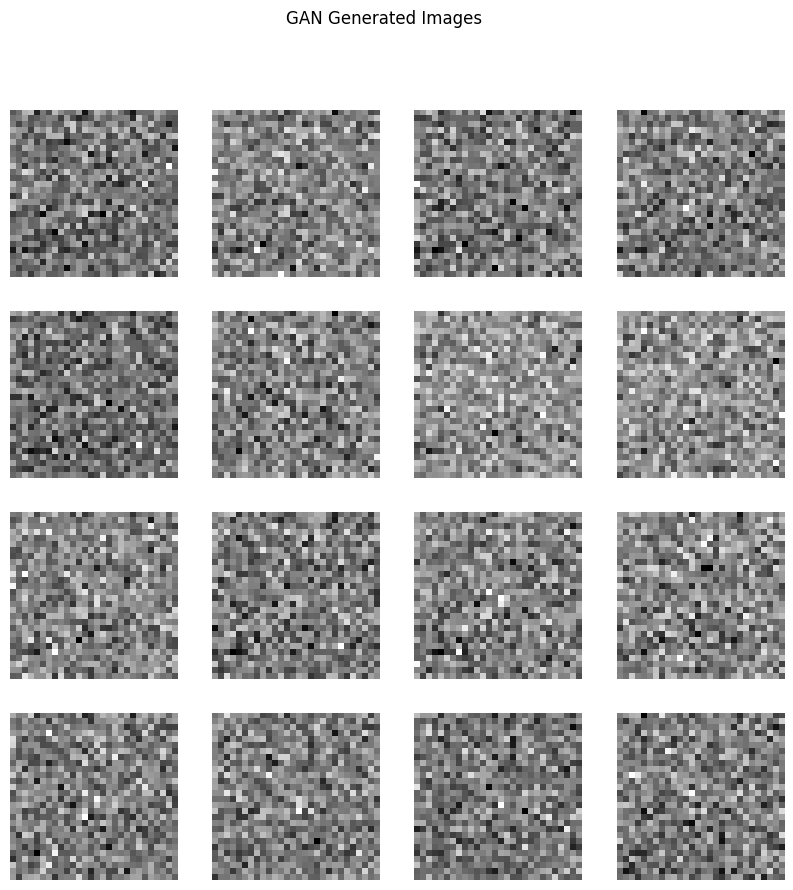


5. GAN Latent Space Interpolation


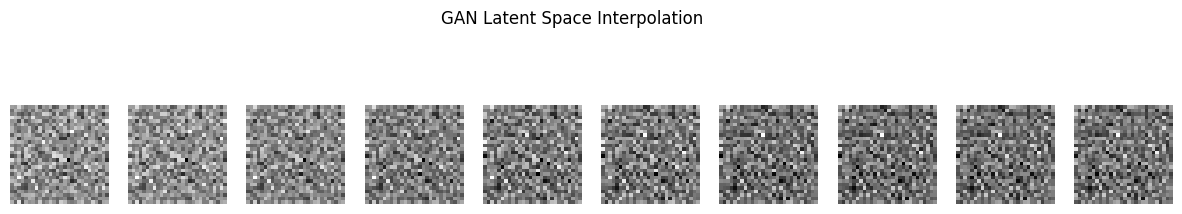

In [5]:
from sklearn.manifold import TSNE
import seaborn as sns
import torch
import numpy as np
import matplotlib.pyplot as plt

class VisualizationHelper:
    @staticmethod
    def visualize_vae_latent_space(vae, test_loader, device='cuda'):
        """Visualize the VAE's latent space using t-SNE"""
        vae.eval()
        latent_vectors = []
        labels = []

        with torch.no_grad():
            for data, label in test_loader:
                data = data.to(device)
                mu, _ = vae.encode(data.view(-1, 784))
                latent_vectors.append(mu.cpu().numpy())
                labels.append(label.numpy())

        # Combine all batches
        latent_vectors = np.concatenate(latent_vectors, axis=0)
        labels = np.concatenate(labels, axis=0)

        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        latent_tsne = tsne.fit_transform(latent_vectors)

        # Plot results
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1],
                              c=labels, cmap='tab10', alpha=0.6)
        plt.colorbar(scatter)
        plt.title('VAE Latent Space Visualization (t-SNE)')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.show()

    @staticmethod
    def visualize_vae_reconstructions(vae, test_loader, device='cuda'):
        """Visualize original and reconstructed images from VAE"""
        vae.eval()
        with torch.no_grad():
            data, _ = next(iter(test_loader))
            data = data.to(device)

            # Get reconstructions
            recon, _, _ = vae(data)

            # Plot original vs reconstructed images
            plt.figure(figsize=(12, 6))

            # Original images
            for i in range(8):
                plt.subplot(2, 8, i + 1)
                plt.imshow(data[i].cpu().view(28, 28).numpy(), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title('Original Images')

            # Reconstructed images
            for i in range(8):
                plt.subplot(2, 8, i + 9)
                plt.imshow(recon[i].cpu().view(28, 28).numpy(), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title('Reconstructed Images')

            plt.tight_layout()
            plt.show()

    @staticmethod
    def visualize_vae_generations(vae, num_images=8, device='cuda'):
        """Generate new images from random points in the VAE's latent space"""
        vae.eval()
        with torch.no_grad():
            # Sample random points from the latent space
            z = torch.randn(num_images, vae.fc_mu.out_features).to(device)
            generated = vae.decode(z)

            plt.figure(figsize=(12, 3))
            for i in range(num_images):
                plt.subplot(1, num_images, i + 1)
                plt.imshow(generated[i].cpu().view(28, 28).numpy(), cmap='gray')
                plt.axis('off')
            plt.suptitle('VAE Generated Images from Random Latent Vectors')
            plt.show()

    @staticmethod
    def visualize_gan_generations(generator, num_images=16, latent_dim=100, device='cuda'):
        """Generate and visualize images from the GAN"""
        generator.eval()
        with torch.no_grad():
            # Generate random latent vectors
            z = torch.randn(num_images, latent_dim).to(device)
            generated = generator(z)

            # Create grid of images
            plt.figure(figsize=(10, 10))
            for i in range(num_images):
                plt.subplot(4, 4, i + 1)
                plt.imshow(generated[i, 0].cpu().view(28, 28).numpy(), cmap='gray')
                plt.axis('off')
            plt.suptitle('GAN Generated Images')
            plt.show()

    @staticmethod
    def visualize_gan_interpolation(generator, num_steps=10, latent_dim=100, device='cuda'):
        """Visualize interpolation between two points in the GAN's latent space"""
        generator.eval()
        with torch.no_grad():
            # Generate two random latent vectors
            z1 = torch.randn(1, latent_dim).to(device)
            z2 = torch.randn(1, latent_dim).to(device)

            # Create interpolation steps
            alphas = np.linspace(0, 1, num_steps)
            interpolated_images = []

            for alpha in alphas:
                z = alpha * z1 + (1 - alpha) * z2
                img = generator(z)
                interpolated_images.append(img.cpu().view(28, 28).numpy())

            # Plot interpolation
            plt.figure(figsize=(15, 3))
            for i in range(num_steps):
                plt.subplot(1, num_steps, i + 1)
                plt.imshow(interpolated_images[i], cmap='gray')
                plt.axis('off')
            plt.suptitle('GAN Latent Space Interpolation')
            plt.show()

    @staticmethod
    def plot_training_progress(losses, model_type='GAN'):
        """Plot training losses over time"""
        plt.figure(figsize=(10, 5))
        if model_type == 'GAN':
            plt.plot(losses['D'], label='Discriminator Loss')
            plt.plot(losses['G'], label='Generator Loss')
        else:  # VAE
            plt.plot(losses['reconstruction'], label='Reconstruction Loss')
            plt.plot(losses['kl'], label='KL Divergence')
            plt.plot(losses['total'], label='Total Loss')

        plt.title(f'{model_type} Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

def visualize_models(vae, generator, test_loader, device='cuda'):
    """Comprehensive visualization of both models"""
    viz = VisualizationHelper()

    print("1. VAE Latent Space Visualization")
    viz.visualize_vae_latent_space(vae, test_loader, device)

    print("\n2. VAE Reconstructions")
    viz.visualize_vae_reconstructions(vae, test_loader, device)

    print("\n3. VAE Generated Images")
    viz.visualize_vae_generations(vae, device=device)

    print("\n4. GAN Generated Images")
    viz.visualize_gan_generations(generator, device=device)

    print("\n5. GAN Latent Space Interpolation")
    viz.visualize_gan_interpolation(generator, device=device)

if __name__ == "__main__":
    # Assuming you have trained VAE and GAN models
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load your trained models
    vae = VAE().to(device)  # Load your trained VAE
    generator = Generator().to(device)  # Load your trained GAN generator

    # Create test dataloader
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = torchvision.datasets.MNIST(
        root='./data', train=False, transform=transform, download=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    # Run visualizations
    visualize_models(vae, generator, test_loader, device)
